# Single Index Model 
***

### Goals:

- Part 1: Compute alpha and Beta of stocks against the S&P100
- Part 2: Construct covariance matrix to test hypothesis that the covariance of a given pair of stocks should be directly proportional to the product of the corresponding 
β
 values

In [3]:
# Import libraries required for computation and analysis
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats

from returns import log_returns

***

## Part 1: Compute alpha and Beta of stocks against the S&P100

### Single index model

\begin{equation*}
    r_{i,t} - r_f = \alpha_i + \beta_i(r_{m,t}-r_f) + \epsilon_{i,t}
\end{equation*}

where:

- $r_{i,t}$ is the return to stock $i$ in stock period $t$
- $r_f$ is the risk-free rate 
- $r_{m,t}$ is the return to the market portfolio
- $\epsilon_{i,t} \sim N(0, \sigma_i)$

### Approach

**Approach :** In terms of the single-index model the alpha is the intercept and the beta is the slope coefficient. In financial terms alpha is the excess return on an investment whilst beta is the the measure of the volatility relative to a benchmark, in this case the S&P 100 index. To find these parameters requires the use of of OLS parameter regression estimation to compute the alpha and beta of each stock.

Before the parameters are computed we have to organise and prepare the data for regression. This requires calculating log returns for all the stocks and the index, then converting them to simple returns, then compute the excess returns which is affected by the risk-free rate and finally the OLS regression.

### Loading financial data

Loading stocks in S&P 100

In [4]:
# Set .csv data file containing stock data to DataFrame prices
prices = pd.read_csv('s_and_p_100.csv')

# Set index of stock prices to dates
prices.set_index(pd.to_datetime(prices['Date']),inplace  = True)
# Removes the column containing dates
prices.drop(columns = 'Date')
# Rename BRK-B stock by changing '-' to '_'
prices = prices.rename(columns = {'BRK-B' : 'BRK_B'})
prices.head(3)

,Date,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2010-01-04,27.406532,NaN,21.194162,35.052402,39.233837,23.243692,25.586843,50.156246,133.899994,...,27.789530,46.125214,19.436718,59.234444,18.397221,21.143955,31.539467,22.523083,44.424107,54.621700
2010-01-05,2010-01-05,27.453915,NaN,21.022924,35.269032,38.844330,22.808218,26.007540,49.721764,134.690002,...,28.176256,46.204498,19.929434,58.349625,18.186405,21.182079,31.285799,23.141388,43.981754,54.834965
2010-01-06,2010-01-06,27.017223,NaN,21.139675,35.643974,38.970917,22.660460,26.015955,49.348106,132.250000,...,28.218761,45.863583,20.141808,58.043648,17.942194,20.573015,31.049047,23.174374,43.883450,55.308914


Loading S&P 100 index 

In [5]:
# import data function from pandas datareader library
from pandas_datareader import data

# Obtain SP100 financial data from yahoo finance for the coresponding dates 
SP100 = data.DataReader("^OEX","yahoo","2010-01-04","2017-11-27")
prices_SP100 = pd.DataFrame({"SP100" : SP100['Adj Close']}, index = SP100.index[:])
returns_SP100_monthly = log_returns(prices_SP100, 'SP100', 'M')
returns_SP100_monthly.head(3)

,SP100
Date,
2010-02-28,0.021916
2010-03-31,0.055443
2010-04-30,0.009989


### Computing log-returns

First step is to compute the log-returns for all the stock in the 'prices' dataframe which contains all the stock prices for the stocks in the S&P 100. This is done by using a for loop which goes through all the stock tickers, then computes the monthly log-returns using the log-return function from exercise 1 then is added to a new dataframe which will contain all the log-returns for the stocks as shown below. Whilst the monthly returns for the index has already been computed in the exercise before.

In [6]:
# Create empty dataframe and assign to variable
all_returns = pd.DataFrame()

# For loop to loop through all stocks in prices dataframe
for i in prices.columns[1:]:
    # Computes log-returns of current stock in for loop
    x = log_returns(prices, i, 'M')
    # Use of concat to add log-returns to dataframe
    all_returns = pd.concat([all_returns, x], axis = 1)

# Return head of data frame
all_returns.head()
    

,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.063347,NaN,0.024997,-0.025199,0.037636,0.022042,0.043158,-0.032499,-0.057520,0.013975,...,0.111631,0.024921,-0.018918,0.023618,0.044877,-0.016796,-0.018596,-0.037356,0.011907,0.015311
2010-03-31,0.138431,NaN,-0.029920,0.048349,0.048563,0.320836,0.039653,0.055489,0.136894,0.081669,...,0.084361,0.092148,0.052239,0.069759,0.065249,0.069753,0.051165,0.129500,0.033524,0.030007
2010-04-30,0.105280,NaN,-0.020889,0.048235,0.024827,0.130525,0.011080,-0.043199,0.009748,0.111353,...,0.031689,0.070864,0.033811,0.018040,-0.008827,-0.055449,-0.053723,0.061985,-0.035888,0.011725
2010-05-31,-0.016256,NaN,-0.072966,-0.151100,0.031958,-0.094848,-0.057797,-0.101471,-0.088724,-0.145623,...,-0.052708,-0.089903,-0.110896,-0.100644,-0.213369,-0.048929,-0.088768,-0.141768,-0.053342,-0.107369
2010-06-30,-0.021047,NaN,-0.016536,0.029673,-0.084791,-0.026928,-0.064038,0.015712,-0.138257,0.000227,...,-0.027247,-0.098198,-0.067417,-0.037347,-0.023882,0.018006,-0.182322,-0.113956,-0.050502,-0.057703


### Computing simple returns

Next step is to compute the simple returns for both the monthly stock returns and the monthly index returns which we have already computed in the exercise before. Simple returns are calculated using the monthly returns by taking the exponential then subtracting one. Once this is done the excess returns for the stocks and the index have to be computed. The excess returns are the simple returns affected by the risk-free rate which in this case is set to 1% which corresponds to 0.01. The risk-free rate is subtracted from the simple returns to give us the excess returns for the individuals stocks and the index. Then the two returns are concatenated into one dataframe as within OLS regression method used will required comparing the individual stock to the index which is done by using the column names so to allow the data to be used requires both excess stock and index returns to be in one dataframe.

In [7]:
# Compute simple returns
stock_simple = np.exp(all_returns) - 1
index_simple = np.exp(returns_SP100_monthly) - 1 

# risk free rate
rr = 0.01

# Compute excess returns
stock_excess = stock_simple - rr
index_excess = index_simple - rr

# Create DataFrame consistsing both stocks and index
OLS_est = pd.concat([index_excess, stock_excess],axis = 1)

OLS_est.head(4)

,SP100,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.012158,0.055396,NaN,0.015312,-0.034884,0.028353,0.012286,0.034103,-0.041977,-0.065897,...,0.108101,0.015234,-0.028740,0.013899,0.035899,-0.026656,-0.028424,-0.046667,0.001978,0.005428
2010-03-31,0.047009,0.138470,NaN,-0.039477,0.039537,0.039761,0.368280,0.030449,0.047057,0.136706,...,0.078022,0.086527,0.043627,0.062250,0.057425,0.062243,0.042497,0.128259,0.024093,0.020461
2010-04-30,0.000039,0.101021,NaN,-0.030672,0.039417,0.015137,0.129426,0.001142,-0.052280,-0.000204,...,0.022196,0.063436,0.024390,0.008204,-0.018788,-0.063940,-0.062305,0.053946,-0.045252,0.001795
2010-05-31,-0.097399,-0.026125,NaN,-0.080367,-0.150238,0.022475,-0.100488,-0.066159,-0.106493,-0.094902,...,-0.061343,-0.095980,-0.114968,-0.105745,-0.202142,-0.057751,-0.094942,-0.142177,-0.061944,-0.111806


### OLS regression

Having processed and organised the data, the OLS regression can be computed. The OLS regression is computed by using a function from another python library called 'statsmodels' which has to be imported. The OLS regression function arguments are the formula which is the current stock in the for loop and the index which is the benchmark. For OLS regression observes the sensitivity/responsiveness of the current stock to the index (benchmark), therefore in the formula argument the index is fixed whilst the stock varies as the OLS regression has to be computed for all stocks. As the for loop goes through each stock ticker, the ticker is used in the formula to use the data for the given stock. The second argument is the data source for the stock/index excess returns which has been created.Lastly, '.fit()' is used to fit the regressed model. Once the regression has been completed the parameters alpha and beta are added to a dataframe for each stock in the prices dataframe.

In [8]:
# Import statsmodels library to workspace
import statsmodels.formula.api as sm 

# Create empty dataframe for alpha and beta values
ab_values = pd.DataFrame()

# Compute OLS regression to obtain alpha and beta using for loop to go through all stocks in prices dataframe
for i in OLS_est.columns[1:]:
    # argument for OLS which contains current stock and fixed index to be regressed 
    formula  = ('%s ~ SP100'%i)
    # Computes OLS regression of formula and fits model
    ols_result = sm.ols(formula = formula, data = OLS_est, missing = 'drop').fit()
    # Add the alpha and beta value for current stock to dataframe
    ab = pd.DataFrame({i : [ols_result.params[0] , ols_result.params[1]]}, index = ['Alpha', 'Beta'])
    # Concats the current stock parameters to dataframe for all stock paramters
    ab_values = pd.concat([ab_values, ab], axis = 1)

ab_values

,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
Alpha,0.013958,0.012273,0.002337,0.007797,0.009092,0.006608,0.006293,0.005158,0.017831,0.003190,...,0.008173,0.001199,0.000983,-0.000359,0.011918,0.001202,0.002017,0.000984,-0.000316,-0.003698
Beta,1.061410,1.502094,0.924220,1.195358,0.547773,1.649650,0.984408,0.893661,1.142452,1.074179,...,0.934603,0.892918,0.962048,1.057362,0.878921,0.512360,1.200494,1.145458,0.361581,0.845238


Having computed alpha and beta we then have to transpose the dataframe which will later allow us to plot the distributed boxplots.

In [9]:
ab_values_T = ab_values.transpose()
ab_values_T

,Alpha,Beta
AAPL,0.013958,1.061410
ABBV,0.012273,1.502094
ABT,0.002337,0.924220
ACN,0.007797,1.195358
AGN,0.009092,0.547773
...,...,...
VZ,0.001202,0.512360
WBA,0.002017,1.200494
WFC,0.000984,1.145458
WMT,-0.000316,0.361581


To observe the alphas and betas for all stocks requires plotting the boxplot for alpha and beta coefficients. As the alphas and betas have different ranges plotting them on the same graph with the same range in the axis will not allow us to observe the alpha as it is much smaller than the beta. Therefore a subplot grid is used which will allow the alpha and beta coefficients to be plotted on the same graph but on different figures which will have different ranges in the axis and allowing the boxplots distributions to be observed.

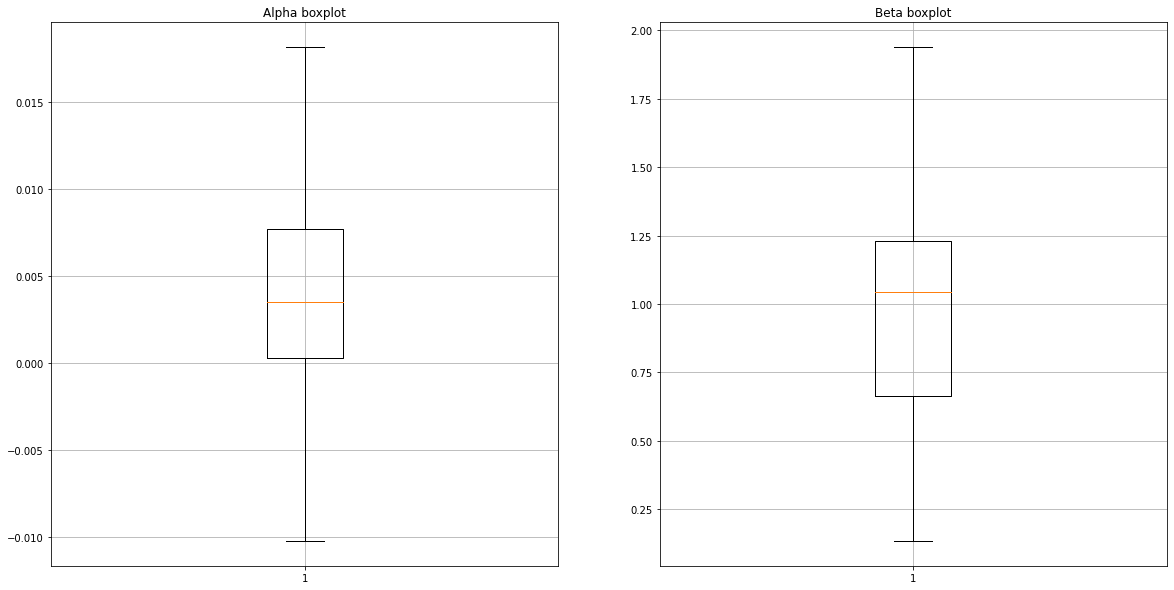

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.boxplot(x = ab_values_T['Alpha'], showfliers = False)
ax1.set_title("Alpha boxplot")
ax1.grid()
ax2.boxplot(x = ab_values_T['Beta'], showfliers = False)
ax2.set_title("Beta boxplot")
plt.grid()
plt.show()

***

##  Part 2: Construct covariance matrix to test hypothesis that the covariance of a given pair of stocks should be directly proportional to the product of the corresponding 
β
 values

### Approach

Accordingly to the single-index model, the covariance for a pair of stocks form the S&P 100 should be directly proportional to the product of beta values for the stock pairs. Direct proportion means an increase in one quantity (covariance of pair) causes a corresponding increase in the other quantity (beta product). To prove this relationship requires computing the covariance and beta products for all given stock pair combinations. Once they are calculated the combination pairs can be plotted on a scatter plot to observe the distribution and to observe any correlations. In addition, OLS regression can be applied to the 2 sets of data to observe the test statistics and allow us to plot the fitted model which will allow better observation if there is direct proportionality. With the fitted model if we can observe a positive gradient will show direct proportionality, however we have to take to account the r-sqaured statistic which indicates correlation between the two quantities.

### Constructing covariance matrix

First we compute the covariance matrix for the monthly excess returns. As we have already computed the monthly excess returns we just have to compute the covariance matrix. As the monthly excess returns are stored in a dataframe we can use the '.cov()' function to compute the covariance matrix.

In [11]:
# Compute covariance matrix for monthly excess returns
returns_cov_matrix = stock_excess.cov()
returns_cov_matrix

,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,...,UNP,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM
AAPL,0.005011,0.000919,0.001245,0.001519,0.000956,0.002100,0.001125,0.000786,0.001894,0.001166,...,0.000553,0.000671,0.000896,0.001136,0.001120,0.000238,0.000994,0.001110,0.000630,0.000563
ABBV,0.000919,0.004321,0.002114,0.001148,0.001009,0.001091,0.001131,0.002464,0.001492,0.001583,...,0.001485,0.001430,0.000769,0.000964,0.000984,0.001107,0.001172,0.001437,0.000566,0.001139
ABT,0.001245,0.002114,0.002571,0.001146,0.001454,0.000878,0.001260,0.001687,0.001498,0.001258,...,0.000705,0.000702,0.000763,0.000906,0.001338,0.000739,0.001435,0.000740,0.000343,0.000567
ACN,0.001519,0.001148,0.001146,0.003215,0.000716,0.002545,0.001435,0.001144,0.001848,0.001468,...,0.001071,0.001051,0.001352,0.001373,0.001343,0.000681,0.001746,0.001361,0.000652,0.001092
AGN,0.000956,0.001009,0.001454,0.000716,0.004959,0.000840,0.000602,0.001428,0.001475,0.000691,...,0.000156,0.000054,0.000487,0.000650,0.000811,0.000348,0.001840,0.000610,-0.000139,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.000238,0.001107,0.000739,0.000681,0.000348,0.000988,0.000676,0.000895,0.000437,-0.000074,...,0.000316,0.000674,0.000334,0.000124,0.000375,0.002308,0.000985,0.000402,0.000552,0.000708
WBA,0.000994,0.001172,0.001435,0.001746,0.001840,0.001982,0.001703,0.001684,0.001715,0.001216,...,0.001130,0.001335,0.001336,0.001586,0.001295,0.000985,0.005614,0.001543,0.000651,0.000959
WFC,0.001110,0.001437,0.000740,0.001361,0.000610,0.003318,0.001138,0.001289,0.000954,0.001992,...,0.001317,0.001398,0.002171,0.001413,0.000914,0.000402,0.001543,0.003144,0.000260,0.001127
WMT,0.000630,0.000566,0.000343,0.000652,-0.000139,-0.000029,0.000923,0.000349,0.000439,0.000179,...,0.000592,0.000434,0.000237,0.000257,0.000247,0.000552,0.000651,0.000260,0.002182,0.000209


As we have to compute all the beta products and covariance for the stock pairs, we have to use a loop or a inbuilt function that will allow us to obtain all the possible combinations for all the stock pairs. This is done by using a function 'combinations' from the 'itertools' library. The library is imported to the workspace, then using the function the arguments is the data source containing the excess stock returns and the second is to indicate it is a pair requires a combination of 2 stocks.

Next we compute the covariance and beta product for all these combination pairs. A for loop is used to go through all these combination pairs and for each pair the covariance is obtained from the covariance matrix using the '.at' function and the beta product is computed by using the data containing alpha and beta values for the stocks, which takes the beta for each stock and multiplies the beta values. A empty list is created at the start and as the for loop goes through each combination pair the covariance and beta product is appended to the list. Once the for loop is executed there are two lists which contains the covariance and beta products for all the pairs.

In [12]:
# Import itertools library
import itertools as iter

# Empty list for covariance of stock pairs created
covariance  = []
# Empty list for beta product of stock pairs created
beta_product = []

# for loop used to go through each stock pair combination
for stock1, stock2 in iter.combinations((stock_excess.columns), 2):
    # Appends covariance for stock pair at current stock combination 
    covariance.append(returns_cov_matrix.at[stock1, stock2])
    # Appends beta product for stock pair at current stock combination 
    beta_product.append(ab_values_T.at[stock1, 'Beta'] * ab_values_T.at[stock2, 'Beta'] )

Having computed the two values which are stored in lists, we can plot a scatter plot of the beta products against the covariance. The scatter plot shows the spread of the combination pairs in terms of their covariance and beta product. They are distributed in compact clusters that follow a directly proportional pattern as the covariance increase so does the beta product. There are outlier as well to this spread, however plotting a regression model will allow a linear observation to show if there is a proportional relationship.

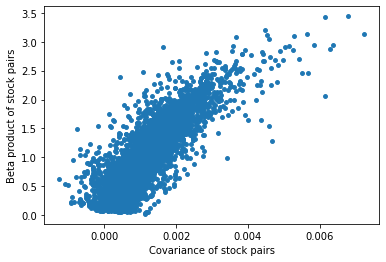

In [13]:
# Scatter plot of beta products vs covariance
plt.scatter(covariance, beta_product, s = 15)
plt.xlabel("Covariance of stock pairs")
plt.ylabel("Beta product of stock pairs")
plt.show()

To observe the OLS regression results, we can use the '.summary function'. Observing the results we can indicate that the linear regression has an intercept (alpha) equal to 0.3585, and a coefficient gradient (beta) equal to 560.65. Using these two parameters we can plot a best fit line to observe the linear regression compared to the scatter of stock pair data. Another key parameter is the r-squared parameter which indicates the correlation between the beta products (dependant variable) and the covariance (benchmark). Typically if the regressed model fits well it will have a r-squared between 0.7 - 1.0 (70% to 100%). The r-squared for the beta products shows a r-squared of 69.5%, which depicts that the 69.5% of the change in the beta product movement can be explained by the movements of the benchmark which is the covariance. The r-squared value is just below the the 70% mark which is still high and shows that it has a high correlation between the the beta products and the covariance.

In [14]:
# Combined dictionary combining both covariance and beta products for pairs
combined = {'cov':covariance, 'beta_prod':beta_product}
# Set formula for OLS regression
formula  = 'beta_prod ~ cov'
# Computes OLS regression of formula and fits model
results = sm.ols(formula = formula, data = combined).fit()
# Show results summary of regression
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              beta_prod   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                 1.175e+04
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:20:26   Log-Likelihood:                -1305.3
No. Observations:                5151   AIC:                             2615.
Df Residuals:                    5149   BIC:                             2628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3585      0.007     49.048      0.000       0.344       0.373
cov          560.6484      5.172    108.404      0.000     550.509     570.787
==============================================================================
Omnibus:                      307.058   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              809.087
Skew:                           0.331   Prob(JB):                    2.04e-176
Kurtosis:                       4.826   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

astly, we can observe the OLS regression by plotting a fit line. Using the y = mx + c formula the intercept c is equal to the alpha and the gradient is equal to the beta value. As we have to multiply a float beta value by the corresponding domain which is the covariance, we cannot simply multiply a list by a float type. Therefore a mapping function is used to map an unknown function lambda to the multiplication of the beta value and covariance values. Having computed that then requires adding the intercept value of alpha, to give us the fit line function values.

The fit line is plotted as well as the scatter plot to observe the proportionality between the two data sets. The fit line fits well as it passes through the centre of dense cluster which is from covariance equal from 0 to 0.003. Whilst towards the higher covariance section of the graph shows a less dense scatter, and the fit line not intercepting these points. This observation relates to the r-squared parameter discussed previously. By observing the fit line shows us a linear association between the beta product and the covariance. As the covariance increases this also leads to an increase in the beta product, therefore indicating the two data sets are directly proportional. The two data sets correlation is only high for most of the stock pairs and is not definite for all stock pairs, which is an important factor to account in testing the hypothesis. As the correlation is high for a large percentage of movements in the beta product, the hypothesis should not be rejected as there is a direct proportionality between the the beta product and the covariance

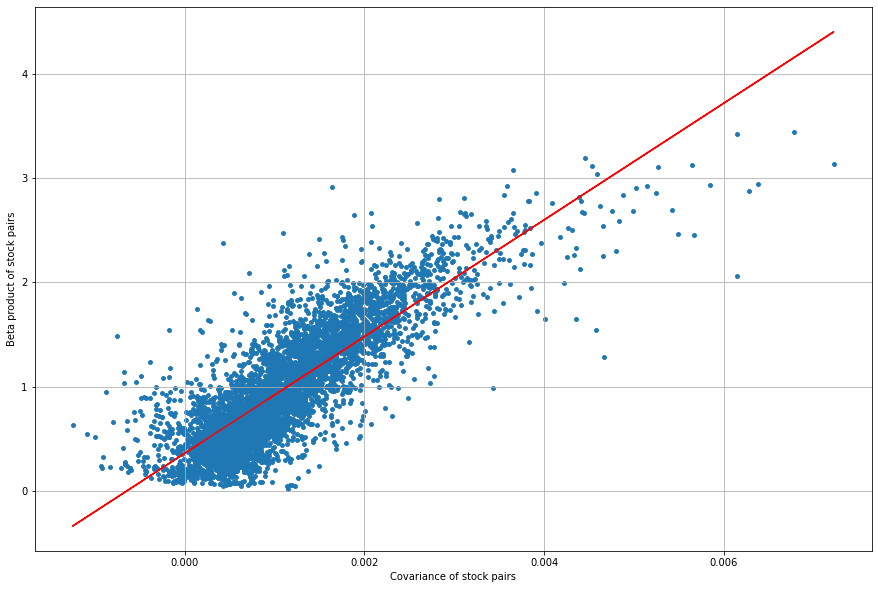

In [17]:
# Assign OLS parameters to variables
a = results.params[0]
b = results.params[1]

# Create fit line for regressed model
fit_line = list(map(lambda x : b * x, covariance)) + a

# Plot fit line and scatter plot
plt.figure(figsize=(15,10))
plt.scatter(covariance, beta_product, s = 15)
plt.plot(covariance, fit_line, color = 'red')

# Label plot 
plt.xlabel("Covariance of stock pairs")
plt.ylabel("Beta product of stock pairs")
plt.grid()
plt.show()